In [1]:
import ROOT as root
import numpy as np

np.random.seed(1234)



Welcome to JupyROOT 6.14/04


In [2]:
#
# Create data
#
# 
# mu = 1
# sigma = 0.2
# 
# data = np.random.normal(mu, sigma, 10)
# 
# print ("data = ", data)
# 
import matplotlib.pyplot as plt
# 
# fig = plt.figure(figsize = (3,3))
# plt.hist( data, bins = 50)


[0, 1]
data_vector_wrong_order
[[1.92073769 2.02512474 2.16707942 ... 2.1017402  2.10953244 2.00308331]
 [3.03830135 2.89604282 2.94442214 ... 2.84590636 2.86855625 2.98397236]]
data_vector_wrong_order_extended
[[3.66926191 4.11364668 3.74558393 ... 4.54848375 3.6083325  3.64397507]
 [4.88385458 4.84929324 5.10401899 ... 4.78342224 4.75688777 5.3749598 ]]
data_vector_wrong_order
[[1.92073769 2.02512474 2.16707942 ... 4.54848375 3.6083325  3.64397507]
 [3.03830135 2.89604282 2.94442214 ... 4.78342224 4.75688777 5.3749598 ]]
data_vector
[[1.92073769 3.03830135]
 [2.02512474 2.89604282]
 [2.16707942 2.94442214]
 ...
 [4.54848375 4.78342224]
 [3.6083325  4.75688777]
 [3.64397507 5.3749598 ]]
data_vector
[[1.0176232  2.12638355]
 [0.97935557 2.00739126]
 [0.97211278 2.06177814]
 ...
 [1.93410387 3.06231269]
 [2.18501105 3.17589858]
 [2.12767644 2.7762441 ]]


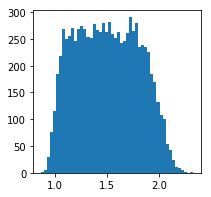

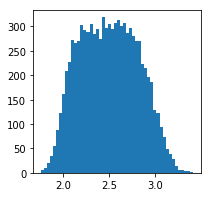

In [44]:
#
# Now create seriously more data in 2D
#

num_events = 9000

dimension_input = 10  # 3

print range(dimension_input)

mu = 2
sigma = 0.1 
data_vector_wrong_order = np.array( [ np.random.normal(mu+i, sigma, num_events*2/3)          for i in range(dimension_input)] )

data_vector_wrong_order_extended = np.array( [ np.random.normal(mu+i+2., 3*sigma, num_events/3) for i in range(dimension_input)] )

print "data_vector_wrong_order"
print data_vector_wrong_order
 
print "data_vector_wrong_order_extended"
print data_vector_wrong_order_extended

# https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.concatenate.html
data_vector_wrong_order = np.concatenate( [data_vector_wrong_order, data_vector_wrong_order_extended], axis=1)

print "data_vector_wrong_order"                                     
print data_vector_wrong_order

data_vector = np.array( [ data_vector_wrong_order[:,i] for i in range(num_events) ] )
print "data_vector"
print data_vector


  
    
#
# New data set
#

import random

data_vector = np.array( [ [ (j + 1 + 1.*i/num_events) * random.gauss(1,0.05)  for j in xrange(dimension_input) ] for i in range(num_events) ] )
    
print "data_vector"
print data_vector



for i in range(dimension_input): 
  fig = plt.figure(figsize = (3,3))  
  plt.hist( data_vector[:,i], bins = 50)


    
    
    


 [ 0 ][ 1 ]


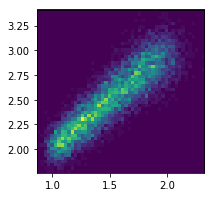

In [45]:
#
# draw 2d correlation (should be null)
#

for i in xrange(dimension_input): 
  for j in xrange(i+1, dimension_input): 
    print " [", i, "][", j, "]"
    fig = plt.figure(figsize = (3,3))  
    plt.hist2d( data_vector[:,i], data_vector[:,j], bins = 50)




In [46]:
#
#
#
# Keras model
#
#

from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential

original_dim = dimension_input
intermediate_dim = 3
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0





In [47]:

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """
    #
    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    #
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    #
    # See: https://keras.io/losses/
    # Cross entropy: https://en.wikipedia.org/wiki/Cross_entropy
    #


In [48]:

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        #
        # var = variance
        #
        # print " mu = ", mu
        # print " log_var = ", log_var
        
        
        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


In [49]:
#
# definition of the decoder
#

decoder = Sequential ([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
    ])



In [50]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

#
# h intermediate step
#
#  - mu = mean
#  - var = variance
#
# explanation see: http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/
#

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#
# from h -> 2 layers
#

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

#
# Add a new layer that takes "t" and does "exp(0.5 * t)", and apply it to "z_log_var"
# See here for more details: https://keras.io/layers/core/
#

eps = Input (tensor = K.random_normal( stddev=epsilon_std, shape=(K.shape(x)[0], latent_dim) ) )

z_eps = Multiply()([z_sigma, eps])
#
# Layer that multiplies (element-wise) a list of inputs.
# It takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).
#

z = Add()([z_mu, z_eps])
#
# Layer that adds a list of inputs.
# It takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).
#

x_pred = decoder(z)


In [51]:

vae = Model ( inputs=[x, eps], outputs=x_pred)
vae.compile (optimizer='rmsprop', loss=nll)


In [52]:

# train the VAE 
x_train = data_vector
x_test  = data_vector


history = vae.fit(x_train,   # source
                  x_train,   # target --> autoencoder, then the target is the same as the input
                  shuffle = True,
                  epochs = epochs,
                  batch_size = batch_size,
                  validation_data = (x_test, x_test))    # target = input also in the testing


Train on 9000 samples, validate on 9000 samples
Epoch 1/50
9000/9000 [==============================] - 1s 81us/step - loss: 2.4707 - val_loss: 1.4794
Epoch 2/50
9000/9000 [==============================] - 0s 49us/step - loss: 0.8965 - val_loss: 0.4181
Epoch 3/50
9000/9000 [==============================] - 0s 47us/step - loss: -0.0752 - val_loss: -0.6505
Epoch 4/50
9000/9000 [==============================] - 0s 46us/step - loss: -1.3209 - val_loss: -2.1111
Epoch 5/50
9000/9000 [==============================] - 0s 46us/step - loss: -2.8761 - val_loss: -3.7484
Epoch 6/50
9000/9000 [==============================] - 0s 46us/step - loss: -4.6447 - val_loss: -5.6094
Epoch 7/50
9000/9000 [==============================] - 0s 41us/step - loss: -6.6123 - val_loss: -7.7697
Epoch 8/50
9000/9000 [==============================] - 0s 47us/step - loss: -8.9575 - val_loss: -10.2757
Epoch 9/50
9000/9000 [==============================] - 0s 42us/step - loss: -11.9115 - val_loss: -13.5218
Epoch 10

In [53]:
encoder = Model(x, z_mu)



In [54]:

# display a plot of the latent space
z_test = encoder.predict(x_test, batch_size = batch_size)



In [55]:
print "z_test = ", z_test

print "x_test = ", x_test



z_test =  [[-0.16820231 -0.73007226]
 [-0.17080563 -0.71434915]
 [-0.16384754 -0.7259073 ]
 ...
 [-0.29126793 -0.7449486 ]
 [-0.33877963 -0.722064  ]
 [-0.36412668 -0.6566711 ]]
x_test =  [[1.0176232  2.12638355]
 [0.97935557 2.00739126]
 [0.97211278 2.06177814]
 ...
 [1.93410387 3.06231269]
 [2.18501105 3.17589858]
 [2.12767644 2.7762441 ]]


latent layer


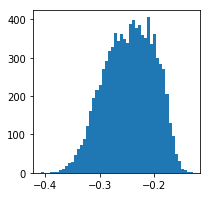

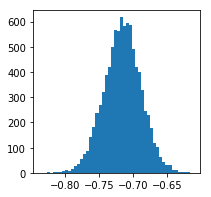

In [56]:
#plt.hist( z_test[:,0], bins = 50)
#plt.hist( x_test[:,0], bins = 50)


print "latent layer"

for inode in range(latent_dim):
  fig = plt.figure(figsize = (3,3))
  plt.hist( z_test[:,inode], bins = 50)




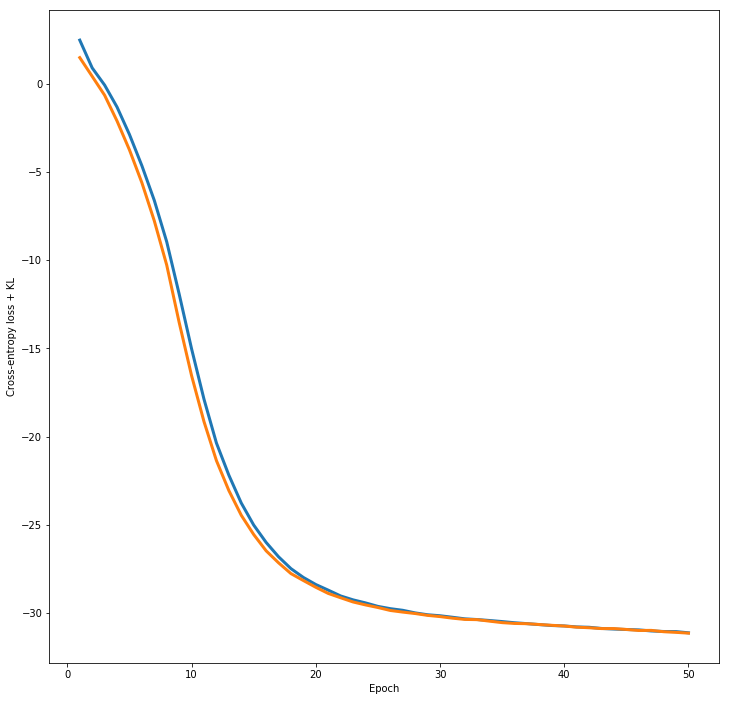

In [57]:


#########################################################
## validation plot

fig_validation = plt.figure(original_dim+latent_dim, figsize=(12,12))

epochs = range(1, len(history.history["loss"])+1)
plt.plot(epochs, history.history["loss"], lw=3, label="Training loss")
plt.plot(epochs, history.history["val_loss"], lw=3, label="Validation loss")
plt.xlabel("Epoch"), plt.ylabel("Cross-entropy loss + KL");

# print(history.history)


In [58]:

#########################################################
## plot structure of NN

from keras.utils import plot_model, print_summary
print_summary(vae)

plot_model(vae, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 3)            9           input_5[0][0]                    
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 2)            8           dense_13[0][0]                   
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 2)            8           dense_13[0][0]                   
__________________________________________________________________________________________________
kl_diverge

2D: reg vs original


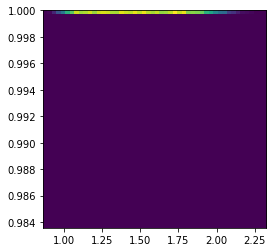

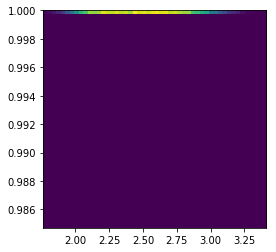

In [59]:
print "2D: reg vs original"

x_reg_test = vae.predict(x_test, batch_size = batch_size)

for inode in range(original_dim):
  fig = plt.figure(figsize = (4,4))
  plt.hist2d( x_test[:,inode], x_reg_test[:,inode], bins = 50)
    
    

input


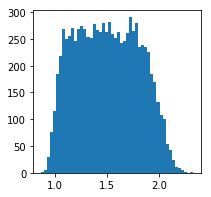

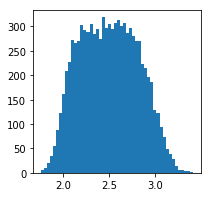

In [60]:

print "input"

for inode in range(original_dim):
  fig = plt.figure(figsize = (3,3))
  plt.hist( x_test[:,inode], bins = 50)


output


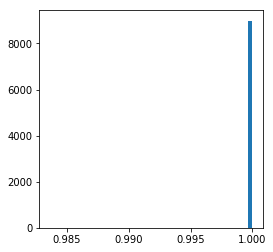

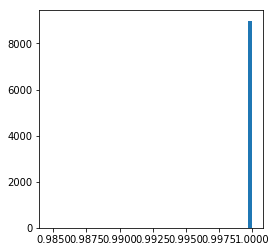

In [61]:
print "output"

for inode in range(original_dim):
   fig = plt.figure(figsize = (4,4))
   plt.hist( x_reg_test[:,inode], bins = 50)
